USAGE<br>
python train_mask_detector.py --dataset dataset

import the necessary packages

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


initialize the initial learning rate, number of epochs to train for,<br>
and batch size

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

grab the list of images in our dataset directory, then initialize<br>
the list of data (i.e., images) and class images

In [4]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("C://Users//Lenovo//Desktop//SOURCECODE//dataset"))
data = []
labels = []

[INFO] loading images...


loop over the image paths

In [10]:
for imagePath in imagePaths:
	# extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

C:\Users\lenovo\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


convert the data and labels to NumPy arrays

In [11]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

perform one-hot encoding on the labels

In [12]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

partition the data into training and testing splits using 75% of<br>
the data for training and the remaining 25% for testing

In [13]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

construct the training image generator for data augmentation

In [14]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

load the MobileNetV2 network, ensuring the head FC layer sets are<br>
left off

In [15]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 1s 0us/step


construct the head of the model that will be placed on top of the<br>
the base model

In [16]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

place the head FC model on top of the base model (this will become<br>
the actual model we will train)

In [17]:
model = Model(inputs=baseModel.input, outputs=headModel)

loop over all layers in the base model and freeze them so they will<br>
*not* be updated during the first training process

In [18]:
for layer in baseModel.layers:
	layer.trainable = False

compile our model

In [19]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


C:\Users\lenovo\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


train the head of the network

In [20]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
96/96 [==============================] - 171s 2s/step - loss: 0.6573 - accuracy: 0.6592 - val_loss: 0.1923 - val_accuracy: 0.9753
Epoch 2/20
96/96 [==============================] - 134s 1s/step - loss: 0.1985 - accuracy: 0.9623 - val_loss: 0.0934 - val_accuracy: 0.9831
Epoch 3/20
96/96 [==============================] - 138s 1s/step - loss: 0.1184 - accuracy: 0.9688 - val_loss: 0.0661 - val_accuracy: 0.9883
Epoch 4/20
96/96 [==============================] - 128s 1s/step - loss: 0.0909 - accuracy: 0.9718 - val_loss: 0.0541 - val_accuracy: 0.9896
Epoch 5/20
96/96 [==============================] - 132s 1s/step - loss: 0.0850 - accuracy: 0.9741 - val_loss: 0.0480 - val_accuracy: 0.9870
Epoch 6/20
96/96 [==============================] - 129s 1s/step - loss: 0.0651 - accuracy: 0.9802 - val_loss: 0.0463 - val_accuracy: 0.9883
Epoch 7/20
96/96 [==============================] - 131s 1s/step - loss: 0.0533 - accuracy: 0.9862 - val_loss: 0.0413 - val_accura

make predictions on the testing set

In [21]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


for each image in the testing set we need to find the index of the<br>
label with corresponding largest predicted probability

In [22]:
predIdxs = np.argmax(predIdxs, axis=1)

serialize the model to disk

In [33]:
print("[INFO] saving mask detector model...")
model.save("mask_detector1.model", save_format="h5")

[INFO] saving mask detector model...


C:\Users\lenovo\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


plot the training loss and accuracy

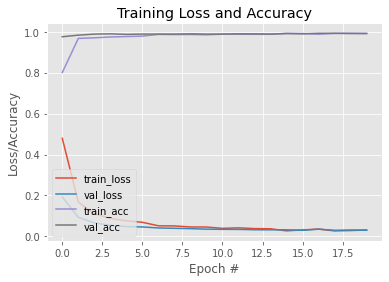

In [34]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot.png")